In [7]:
"""
@author: Miao-Chin Yen
"""

from ast import Str
from typing import List
import matplotlib.pyplot as plt

In [8]:
class PriceAndShares:
    
    def __init__(self, price, shares) -> None:
        self.price: float  = price
        self.shares: int = shares

PriceSizePairs = List[PriceAndShares]


class OrderBook:
    
    def __init__(self, descending_bids, ascending_asks):
        self.descending_bids: PriceSizePairs = descending_bids
        self.ascending_asks: PriceSizePairs = ascending_asks

    def bid_price(self) -> float:
        return self.descending_bids[0].price

    def ask_price(self) -> float:
        return self.ascending_asks[0].price

    def mid_price(self) -> float:
        return (self.bid_price() + self.ask_price()) / 2

    def bid_ask_spread(self) -> float:
        return self.ask_price() - self.bid_price()

    def market_depth(self) -> float:
        return self.ascending_asks[-1].price - self.descending_bids[-1].price
        
    ''' zero_out: delete the price in orderbook with shares equal to 0'''
    def zero_out(self, type: Str) -> None:
        if type == 'Bid':
            self.descending_bids = list(filter(lambda x: x.shares != 0, self.descending_bids))
        else:
            self.ascending_asks = list(filter(lambda x: x.shares != 0, self.ascending_asks))
            
    ''' remove: remove bid/ask order'''     
    def remove(self, index: int, shares: int, type: Str) -> None:
        if shares > 0:
            if type == 'Ask':
                self.ascending_asks[index].shares -= shares
                print('Remove '  + str(shares) + ' shares with price ' + str(self.ascending_asks[index].price) + ' from the ask side')
            else:
                self.descending_bids[index].shares -= shares
                print('Remove '  + str(shares) + ' shares with price ' + str(self.descending_bids[index].price)  + ' from the bid side')
            
    ''' add: add bid/ask order'''
    def add(self, price: float, shares: int, type: Str) -> None:
        if shares > 0:
            if type == 'Ask':
                price_index = 0
                while price > self.ascending_asks[price_index].price and price_index < len(self.ascending_asks) - 1:
                    price_index += 1
                if  price == self.ascending_asks[price_index].price:
                    self.ascending_asks[price_index].shares += shares
                else:
                    if price_index ==  len(self.ascending_asks) - 1:
                        self.ascending_asks.append(PriceAndShares(price, shares))
                    else:
                        self.ascending_asks.insert(price_index, PriceAndShares(price, shares))
            else:
                price_index = 0
                while price < self.descending_bids[price_index].price and price_index < len(self.descending_bids) - 1:
                    price_index += 1
                if price == self.descending_bids[price_index].price:
                    self.descending_bids[price_index].shares += shares
                else:
                    if price_index == len(self.descending_bids) - 1:
                        self.descending_bids.append(PriceAndShares(price, shares))
                    else:    
                        self.descending_bids.insert(price_index, PriceAndShares(price, shares))
            print('Add '  + str(shares) + ' shares with ' + type + ' price ' + str(price) )
    
    def dynamic_aux(self, max_index: int, price: float, shares: int, type: Str, order_type: Str) -> None:
        if type == 'Ask':
            add_type = 'Bid'
            target_part = self.ascending_asks
        else:
            add_type = 'Ask'
            target_part = self.descending_bids
        share_count = 0
        if order_type == 'LO':
            max_index += 1
        for i in range(max_index):
            share_count_temp = target_part[i].shares
            self.remove(i, min(target_part[i].shares, max(0, shares - share_count)), type)
            share_count += share_count_temp
        if order_type == 'LO':
            self.add(price, max(0, shares - share_count), add_type)
        self.zero_out(type)
            
    def sell_limit_order(self, price: float, shares: int) -> None:
        price_index = 0 
        while price <= self.descending_bids[price_index].price and price_index < len(self.descending_bids) - 1:
            price_index += 1
        if price > self.descending_bids[price_index].price:
            price_index -= 1
        self.dynamic_aux(price_index, price, shares, 'Bid', 'LO')

    def sell_market_order(self, shares: int) -> None:
        self.dynamic_aux(len(self.descending_bids), None, shares, 'Bid', 'MO')
    
    def buy_limit_order(self, price: float, shares: int) -> None:
        price_index = 0 
        while price >= self.ascending_asks[price_index].price and price_index < len(self.ascending_asks) - 1:
            price_index += 1
        if price < self.ascending_asks[price_index].price:
            price_index -= 1
        self.dynamic_aux(price_index, price, shares, 'Ask', 'LO')

    def buy_market_order(self, shares: int) -> None:
        self.dynamic_aux(len(self.ascending_asks), None, shares, 'Ask', 'MO')
    
    def pretty_print_order_book(self) -> None:
        from pprint import pprint
        print()
        print("Bids")
        for b in list(self.descending_bids):
            print('Price: ',b.price, 'Shares: ', b.shares)
        print()
        print("Asks")
        print()
        for a in list(self.ascending_asks):
            print('Price: ',a.price, 'Shares: ', a.shares)
        print()

    def display_order_book(self) -> None:

        bid_prices = [d_s.price for d_s in self.descending_bids]
        bid_shares = [d_s.shares for d_s in self.descending_bids]
        if self.descending_bids:
            plt.bar(bid_prices, bid_shares, color='lightseagreen')

        ask_prices = [d_s.price for d_s in self.ascending_asks]
        ask_shares = [d_s.shares for d_s in self.ascending_asks]
        if self.ascending_asks:
            plt.bar(ask_prices, ask_shares, color='orange')

        all_prices = sorted(bid_prices + ask_prices)
        all_ticks = ["%d" % x for x in all_prices]
        plt.xticks(all_prices, all_ticks)
        plt.grid(axis='y')
        plt.xlabel("Prices")
        plt.ylabel("Number of Shares")
        plt.title("Order Book")
        plt.show()
            



Bids
Price:  100 Shares:  109
Price:  99 Shares:  87
Price:  98 Shares:  73
Price:  97 Shares:  70
Price:  96 Shares:  73
Price:  95 Shares:  57
Price:  94 Shares:  45
Price:  93 Shares:  29
Price:  92 Shares:  21
Price:  91 Shares:  7

Asks

Price:  105 Shares:  105
Price:  106 Shares:  79
Price:  107 Shares:  83
Price:  108 Shares:  77
Price:  109 Shares:  55
Price:  110 Shares:  50
Price:  111 Shares:  44
Price:  112 Shares:  35
Price:  113 Shares:  21
Price:  114 Shares:  10



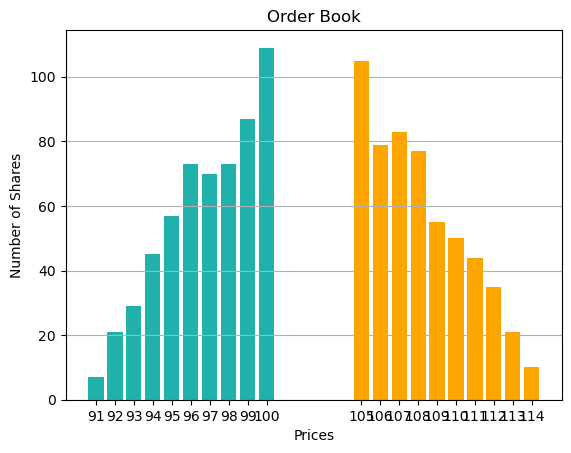

Best Bid Price:  100
Best Ask Price:  105
Sell Limit Order of (107, 45)

Add 45 shares with Ask price 107

Bids
Price:  100 Shares:  109
Price:  99 Shares:  87
Price:  98 Shares:  73
Price:  97 Shares:  70
Price:  96 Shares:  73
Price:  95 Shares:  57
Price:  94 Shares:  45
Price:  93 Shares:  29
Price:  92 Shares:  21
Price:  91 Shares:  7

Asks

Price:  105 Shares:  105
Price:  106 Shares:  79
Price:  107 Shares:  128
Price:  108 Shares:  77
Price:  109 Shares:  55
Price:  110 Shares:  50
Price:  111 Shares:  44
Price:  112 Shares:  35
Price:  113 Shares:  21
Price:  114 Shares:  10



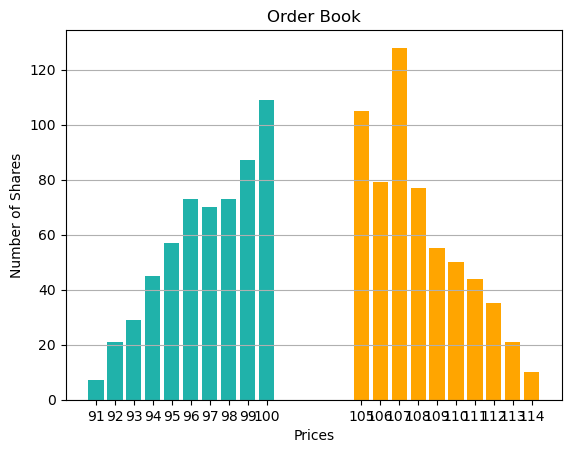

Best Bid Price:  100
Best Ask Price:  105
Sell Market Order of 110

Remove 109 shares with price 100 from the bid side
Remove 1 shares with price 99 from the bid side

Bids
Price:  99 Shares:  86
Price:  98 Shares:  73
Price:  97 Shares:  70
Price:  96 Shares:  73
Price:  95 Shares:  57
Price:  94 Shares:  45
Price:  93 Shares:  29
Price:  92 Shares:  21
Price:  91 Shares:  7

Asks

Price:  105 Shares:  105
Price:  106 Shares:  79
Price:  107 Shares:  128
Price:  108 Shares:  77
Price:  109 Shares:  55
Price:  110 Shares:  50
Price:  111 Shares:  44
Price:  112 Shares:  35
Price:  113 Shares:  21
Price:  114 Shares:  10



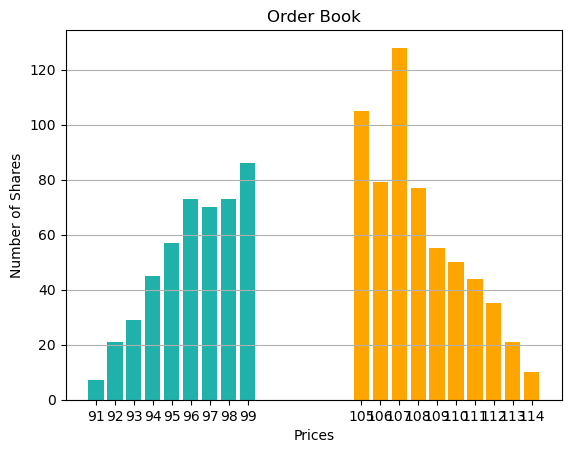

Best Bid Price:  99
Best Ask Price:  105
Buy Limit Order of (107, 230)

Remove 105 shares with price 105 from the ask side
Remove 79 shares with price 106 from the ask side
Remove 46 shares with price 107 from the ask side

Bids
Price:  99 Shares:  86
Price:  98 Shares:  73
Price:  97 Shares:  70
Price:  96 Shares:  73
Price:  95 Shares:  57
Price:  94 Shares:  45
Price:  93 Shares:  29
Price:  92 Shares:  21
Price:  91 Shares:  7

Asks

Price:  107 Shares:  82
Price:  108 Shares:  77
Price:  109 Shares:  55
Price:  110 Shares:  50
Price:  111 Shares:  44
Price:  112 Shares:  35
Price:  113 Shares:  21
Price:  114 Shares:  10



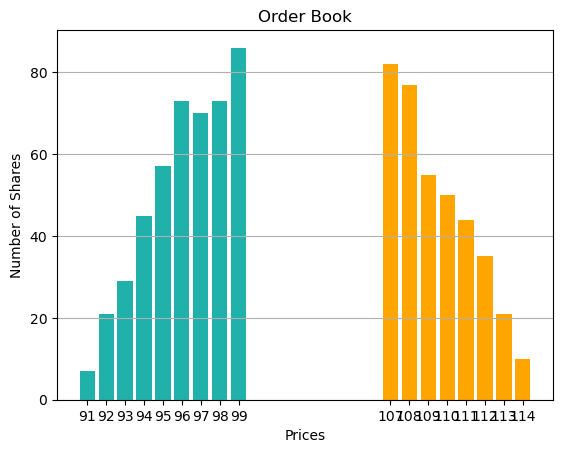

Best Bid Price:  99
Best Ask Price:  107
Sell Limit Order of (93, 170)

Remove 86 shares with price 99 from the bid side
Remove 73 shares with price 98 from the bid side
Remove 11 shares with price 97 from the bid side

Bids
Price:  97 Shares:  59
Price:  96 Shares:  73
Price:  95 Shares:  57
Price:  94 Shares:  45
Price:  93 Shares:  29
Price:  92 Shares:  21
Price:  91 Shares:  7

Asks

Price:  107 Shares:  82
Price:  108 Shares:  77
Price:  109 Shares:  55
Price:  110 Shares:  50
Price:  111 Shares:  44
Price:  112 Shares:  35
Price:  113 Shares:  21
Price:  114 Shares:  10



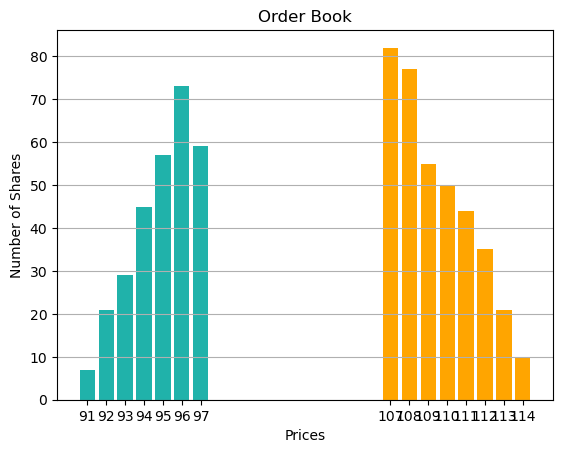

Best Bid Price:  97
Best Ask Price:  107
Buy Market Order of 200

Remove 82 shares with price 107 from the ask side
Remove 77 shares with price 108 from the ask side
Remove 41 shares with price 109 from the ask side

Bids
Price:  97 Shares:  59
Price:  96 Shares:  73
Price:  95 Shares:  57
Price:  94 Shares:  45
Price:  93 Shares:  29
Price:  92 Shares:  21
Price:  91 Shares:  7

Asks

Price:  109 Shares:  14
Price:  110 Shares:  50
Price:  111 Shares:  44
Price:  112 Shares:  35
Price:  113 Shares:  21
Price:  114 Shares:  10



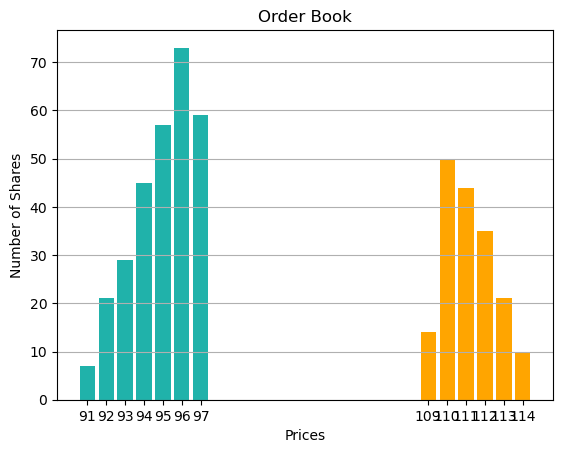

Best Bid Price:  97
Best Ask Price:  109


In [9]:
from numpy.random import poisson

bids: PriceSizePairs = [PriceAndShares(
    price = x,
    shares = poisson(100. - (100 - x) * 10)
) for x in range(100, 90, -1)]
asks: PriceSizePairs = [PriceAndShares(
    price = x,
    shares = poisson(100. - (x - 105) * 10)
) for x in range(105, 115, 1)]

asks = sorted(asks, key=lambda x: x.price)
bids = sorted(bids, key=lambda x: x.price)
bids.reverse()

ob: OrderBook = OrderBook(descending_bids=bids, ascending_asks=asks)
ob.pretty_print_order_book()
ob.display_order_book()
print('Best Bid Price: ', ob.bid_price())
print('Best Ask Price: ', ob.ask_price())

print("Sell Limit Order of (107, 45)")
print()
ob.sell_limit_order(107, 45)
ob.pretty_print_order_book()
ob.display_order_book()
print('Best Bid Price: ', ob.bid_price())
print('Best Ask Price: ', ob.ask_price())


print("Sell Market Order of 110")
print()
ob.sell_market_order(110)
ob.pretty_print_order_book()
ob.display_order_book()
print('Best Bid Price: ', ob.bid_price())
print('Best Ask Price: ', ob.ask_price())


print("Buy Limit Order of (107, 230)")
print()
ob.buy_limit_order(107, 230)
ob.pretty_print_order_book()
ob.display_order_book()
print('Best Bid Price: ', ob.bid_price())
print('Best Ask Price: ', ob.ask_price())

print("Sell Limit Order of (93, 170)")
print()
ob.sell_limit_order(93, 170)
ob.pretty_print_order_book()
ob.display_order_book()
print('Best Bid Price: ', ob.bid_price())
print('Best Ask Price: ', ob.ask_price())

print("Buy Market Order of 200")
print()
ob.buy_market_order(200)
ob.pretty_print_order_book()
ob.display_order_book()
print('Best Bid Price: ', ob.bid_price())
print('Best Ask Price: ', ob.ask_price())
